In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
import numpy as np
import random
import torch
import bayesflow as bf
import matplotlib.pyplot as plt
import pandas as pd
from keras import Model
from keras.layers import Dense, LSTM, Conv1D
from keras.initializers import RandomNormal
from keras.models import Sequential
from keras import ops

from data_utils import DataSimulator
from metrics import multimodel_accuracy
from losses import multimodel_exponential_loss
from simulator import random_walk

INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


In [2]:
print(f"Using Keras backend: {keras.backend.backend()}")

print("CUDA available:", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

np.random.seed(17)
random.seed(17)
torch.manual_seed(17)

Using Keras backend: torch
CUDA available: True
GPU device: NVIDIA GeForce RTX 4080 Laptop GPU


In [3]:
def simulator(n_sims, n_steps=100):
    returns_all = np.zeros((n_sims, n_steps), dtype=np.float32)
    models_all  = np.zeros((n_sims, n_steps), dtype=np.int32)

    for i in range(n_sims):
        returns, models = random_walk(n_steps)
        returns_all[i] = returns
        models_all[i]  = models

    return returns_all, models_all



In [4]:
def loss_wrapper(y_true_batch, f_x_batch):
    y_true_flat = ops.reshape(y_true_batch, [-1, 1])
    f_x_flat = ops.reshape(f_x_batch, [-1, ops.shape(f_x_batch)[-1]])
    
    # Call your math-verified loss function
    return multimodel_exponential_loss(y_true_flat, f_x_flat)


def batch_multimodel_accuracy(y_true_batch, f_x_batch):
    batch_size = ops.shape(y_true_batch)[0]
    accs = []

    for b in range(batch_size):
        y_true_b = y_true_batch[b] 
        f_x_b = f_x_batch[b]       

        f0 = ops.zeros_like(f_x_b)
        fx_full = ops.concatenate([f0, f_x_b], axis=1)  

        preds = ops.argmin(fx_full, axis=1)

        correct = ops.equal(preds, ops.cast(y_true_b[:, 0], "int32"))
        accs.append(ops.mean(ops.cast(correct, f_x_b.dtype)))

    return ops.mean(ops.stack(accs))

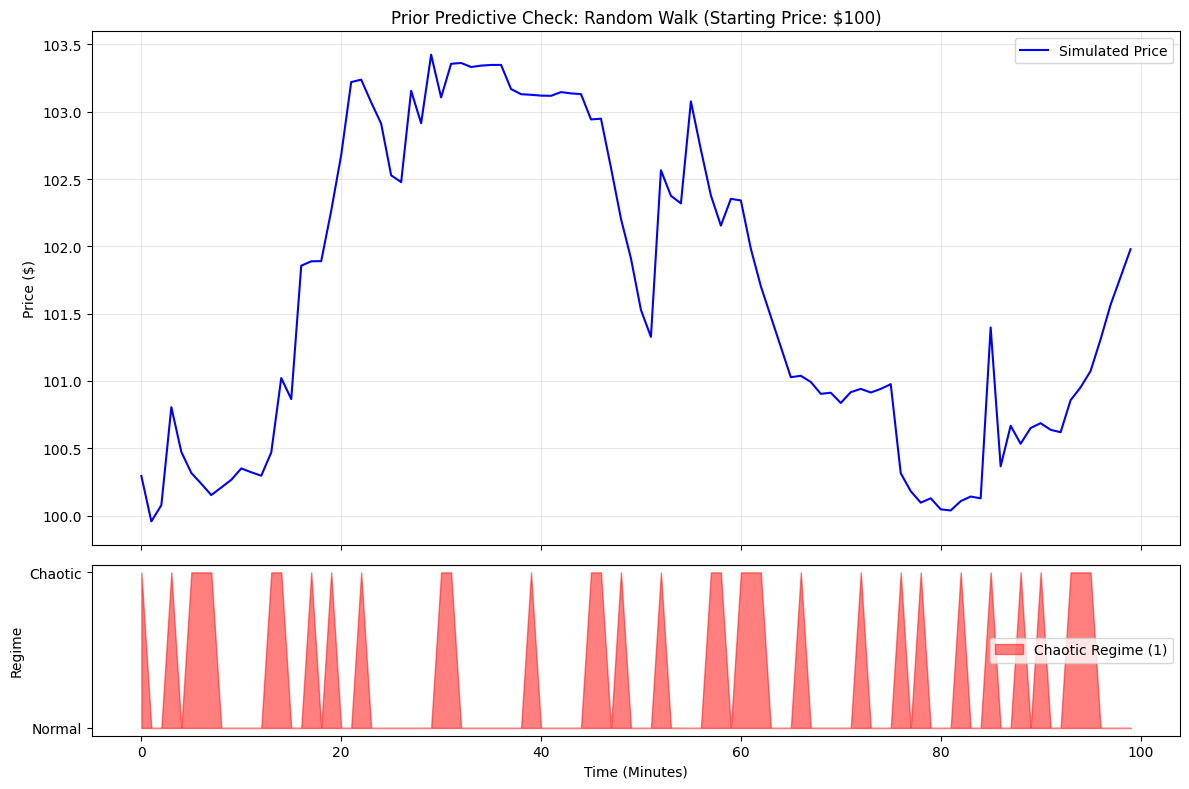

In [5]:
n_steps = 100  
returns, models = random_walk(n_steps)

start_price = 100
price_path = start_price * np.exp(np.cumsum(returns))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(price_path, color='blue', linewidth=1.5, label='Simulated Price')
ax1.set_title(f"Prior Predictive Check: Random Walk (Starting Price: ${start_price})")
ax1.set_ylabel("Price ($)")
ax1.grid(True, alpha=0.3)
ax1.legend()


ax2.fill_between(range(n_steps), 0, models, color='red', alpha=0.5, label='Chaotic Regime (1)')
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Normal', 'Chaotic'])
ax2.set_ylabel("Regime")
ax2.set_xlabel("Time (Minutes)")
ax2.legend()

plt.tight_layout()
plt.show()

In [6]:
# Network
class BayesEvidenceNetwork(Model):
    def __init__(self, num_models, **kwargs):
        super().__init__(**kwargs)

        # shared backbone network
        self.summary_network = Sequential([
            
            Conv1D(256, kernel_size=9, padding='same', activation='swish'),  # local context
            Conv1D(128, kernel_size=9, padding='same', activation='swish'),
            keras.layers.Bidirectional(LSTM(256, return_sequences=True))
            ])
        self.classification_network = Sequential([
            Dense(128, activation='swish'),
            Dense(128, activation='swish'),
        ])

        self.output_layer = Dense(num_models-1, activation=None,
                                  kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))  # unbounded

    def call(self, x, training=False):
        x = self.summary_network(x, training=training)
        x = self.classification_network(x, training=training)
        return self.output_layer(x)


In [7]:
# Data Preparation
BATCH_SIZE = 32
TRAIN_BATCHES = 200
VAL_BATCHES = 30
EPOCHS = 20

train_loader = DataSimulator(
    batches_per_epoch=TRAIN_BATCHES,
    simulator=simulator,
    batch_size=BATCH_SIZE,
)

# Validation loader
val_loader = DataSimulator(
    batches_per_epoch=VAL_BATCHES,
    simulator=simulator,
    batch_size=BATCH_SIZE,
)

In [8]:
x, y = train_loader[0]

print(x.shape)
print(y.shape)

(32, 100, 1)
(32, 100, 1)


In [9]:
# Compile model

lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-5, decay_steps=EPOCHS * len(train_loader)
)
optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule)

model = BayesEvidenceNetwork(2)

model.compile(
    optimizer=optimizer,
    loss=loss_wrapper,
    metrics=[batch_multimodel_accuracy]
)

In [10]:
X_batch, y_batch = train_loader[0]
print("X_batch shape:", X_batch.shape)

y_pred = model(X_batch, training=False)
print("Output shape:", ops.shape(y_pred))

X_batch shape: (32, 100, 1)
Output shape: (32, 100, 1)


In [11]:
# Train model

with torch.enable_grad(): 
    history = model.fit(
        train_loader,
        validation_data=val_loader,
        epochs=EPOCHS,
        verbose=1
    )

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 413ms/step - batch_multimodel_accuracy: 0.6997 - loss: 1.9483 - val_batch_multimodel_accuracy: 0.6968 - val_loss: 1.9212
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 73s 364ms/step - batch_multimodel_accuracy: 0.6986 - loss: 1.9186 - val_batch_multimodel_accuracy: 0.6985 - val_loss: 1.9179
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 74s 372ms/step - batch_multimodel_accuracy: 0.7002 - loss: 1.9164 - val_batch_multimodel_accuracy: 0.7023 - val_loss: 1.9146
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 85s 426ms/step - batch_multimodel_accuracy: 0.7001 - loss: 1.9165 - val_batch_multimodel_accuracy: 0.6973 - val_loss: 1.9190
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 376ms/step - batch_multimodel_accuracy: 0.7002 - loss: 1.9164 - val_batch_multimodel_accuracy: 0.6973 - val_loss: 1.9190
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 376ms/step - batch_multimodel_accuracy: 0.6999 - loss: 1.9167 - val_batch_multimodel_accuracy: 0.7018 - val_loss: 1.9150
Epoch 7/20

KeyboardInterrupt: 

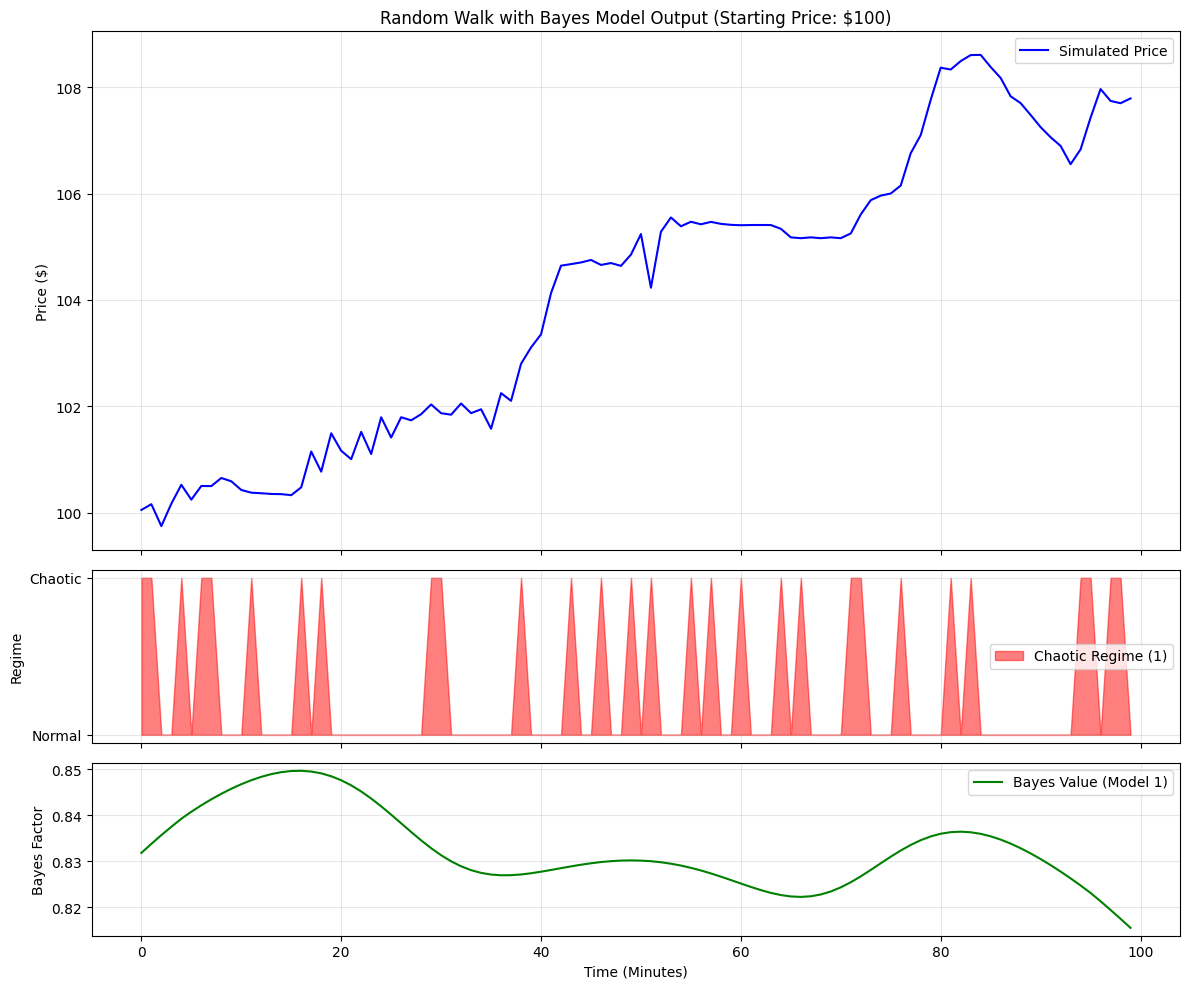

In [12]:
n_steps = 100
returns, models = random_walk(n_steps)

start_price = 100
price_path = start_price * np.exp(np.cumsum(returns))

# Convert to the input shape expected by your model: (1, n_steps, 1)
X_sim = np.array(returns, dtype=np.float32).reshape(1, n_steps, 1)

# Run model to get Bayes values (assuming model outputs (1, n_steps, 1) for 2 models)
bayes_values = model(X_sim, training=False).cpu().detach().numpy().squeeze()

# Plot price, regimes, and Bayes value
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True, 
                                    gridspec_kw={'height_ratios': [3, 1, 1]})

# Price
ax1.plot(price_path, color='blue', linewidth=1.5, label='Simulated Price')
ax1.set_title(f"Random Walk with Bayes Model Output (Starting Price: ${start_price})")
ax1.set_ylabel("Price ($)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# True regime
ax2.fill_between(range(n_steps), 0, models, color='red', alpha=0.5, label='Chaotic Regime (1)')
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Normal', 'Chaotic'])
ax2.set_ylabel("Regime")
ax2.grid(True, alpha=0.3)
ax2.legend()

# Bayes values from the model
ax3.plot(bayes_values, color='green', linewidth=1.5, label='Bayes Value (Model 1)')
ax3.set_ylabel("Bayes Factor")
ax3.set_xlabel("Time (Minutes)")
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

In [13]:
print(f"\nLoss History")
bf.diagnostics.plots.loss(history=history)
plt.show()


Loss History


NameError: name 'history' is not defined

In [14]:
with torch.enable_grad(): 
    X_batch, y_batch = next(iter(train_loader))

    loss_val = loss_wrapper(y_batch, model(X_batch))
    loss_val.backward()

    # Check gradients
    for name, param in model.named_parameters():
        if param.grad is None:
            print(name, "has no gradient")
        else:
            print(name, "grad norm:", param.grad.norm().item())

_torch_params.bayes_evidence_network/dense_2/bias grad norm: 0.003454734105616808
_torch_params.bayes_evidence_network/dense_2/kernel grad norm: 0.04215635359287262
_torch_params.bayes_evidence_network/sequential/bidirectional/backward_lstm/lstm_cell/bias grad norm: 0.0003995446895714849
_torch_params.bayes_evidence_network/sequential/bidirectional/backward_lstm/lstm_cell/kernel grad norm: 7.760760490782559e-05
_torch_params.bayes_evidence_network/sequential/bidirectional/backward_lstm/lstm_cell/recurrent_kernel grad norm: 0.0030945392791181803
_torch_params.bayes_evidence_network/sequential/bidirectional/forward_lstm/lstm_cell/bias grad norm: 0.0008909534080885351
_torch_params.bayes_evidence_network/sequential/bidirectional/forward_lstm/lstm_cell/kernel grad norm: 0.0001586519938427955
_torch_params.bayes_evidence_network/sequential/bidirectional/forward_lstm/lstm_cell/recurrent_kernel grad norm: 0.00206113257445395
_torch_params.bayes_evidence_network/sequential/conv1d/bias grad nor